The primary objective of this competition is to employ deep learning-based regression models, such as Convolutional Neural Networks (CNNs) like ConvNext or Transformers, to predict plant traits from photographs. These plant traits, although available for each image, may not yield exceptionally high accuracies due to the inherent heterogeneity of citizen science data. The various plant traits describe chemical tissue properties that are loosely related to the visible appearance of plants in images. Despite the anticipated moderate accuracies, the overarching goal is to explore the potential of this approach and gain insights into global changes affecting ecosystems. Your contribution to uncovering the wealth of data and the distribution of plant traits worldwide is invaluable.

Our goal is to predict a broad set of 6 plant traits (e.g. leaf area, plant height) from crowd-sourced plant images and some ancillary data. 

The models will be evaluated against the independent test data. The evaluation metric for this competition is the mean R2 over all 6 traits. The R2 is commonly used for evaluating regression models and is the ratio of the sum of squares the residuals (SSres) to the total sum of squares (SStot).

The R2 can result in large negative values. To prevent that we will only consider R2 values > 0.

The submission should include a .csv file with a prediction for each trait and the following columns: id (see labels) and a prediction for each trait (X1080, X50, …). An example is given with sample_submission.csv


In [107]:
#imports and variables
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

DATA_DIR = os.getcwd() +'/data/' #data directory kaggle: /kaggle/input/planttraits2024/

In [108]:
class CONFIG:
    sub = f"{DATA_DIR}sample_submission.csv"
    trgts = f"{DATA_DIR}target_name_meta.tsv"
    train_path = f"{DATA_DIR}train.csv"
    test_path = f"{DATA_DIR}test.csv"
    train_image_path = f"{DATA_DIR}train_images/"
    test_image_path = f"{DATA_DIR}test_images/"
    SEED = 42 #seed for reproducibility
    IMAGE_SIZE = [224, 224] 
    BATCH_SIZE = 128
    EPOCHS = 8
    CLASS_NAMES  =['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean'] #target columns in dataset to predict

    aux_class_names = list(map(lambda x: x.replace("mean","sd"), CLASS_NAMES))
    num_classes = len(CLASS_NAMES)
    aux_num_classes = len(aux_class_names)

config = CONFIG()
len(CONFIG.CLASS_NAMES)

6

In [109]:
#load train.csv and test.csv as pandas dataframe
train = pd.read_csv(config.train_path)
test = pd.read_csv(config.test_path)

In [110]:
#add image path to the dataframe
train['image_path'] = f'{DATA_DIR}/train_images/' + train['id'].astype(str) + '.jpeg'
test['image_path'] = f'{DATA_DIR}/test_images/' + test['id'].astype(str) + '.jpeg'

# drop missing values in the target columns
train = train.drop_duplicates(subset=['id']).dropna(subset=CONFIG.CLASS_NAMES)
display(train.head(2))

FEATURE_COLS = test.columns[1:-1].tolist()


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,D:\Adulthood funkek\NUS Master in AI\Semester ...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,D:\Adulthood funkek\NUS Master in AI\Semester ...


In [111]:
#this is just to check if everything is working fine
train.loc[train['id'] == 100010249, config.CLASS_NAMES]

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
24553,0.47654,11.378406,6.366832,45.152675,1.910018,3937.028466


In [112]:
#additional libraries
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

In [113]:
#get all tabular features
train_all_tabular = train.iloc[:, 1:-7]
test_df = test.iloc[:,1:-1]
#use 80/20 split
train_df, val_df = train_test_split(train_all_tabular, test_size=0.2, random_state=config.SEED)
print(f"Train shape: {train_df.shape}, Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")


#get soil and climate data only...



Train shape: (44391, 169), Validation shape: (11098, 169)
Test shape: (6545, 163)


In [114]:
#define Dataset class
class PlantTabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_input_dimensions(self):
        return self.X.size(1)
    
    def get_output_dimensions(self):
        return self.y.size(1)

In [115]:
#train with all tabular data
train_input = train_df.iloc[:,:-6]
train_output = train_df.iloc[:,-6:]
val_input = val_df.iloc[:,:-6]
val_output = val_df.iloc[:,-6:]

test_input = test_df

#normalize inputs
scaler = MinMaxScaler()
scaler.fit(train_input)
train_input = scaler.transform(train_input)
val_input = scaler.transform(val_input)
train_output.iloc[:,1:] = train_output.iloc[:,1:].apply(lambda x: np.log10(x))
val_output.iloc[:,1:] = val_output.iloc[:,1:].apply(lambda x: np.log10(x))

test_input = scaler.transform(test_input)

#initialize Dataset
train_data = PlantTabularDataset(train_input, train_output)
val_data = PlantTabularDataset(val_input, val_output)
test_data = torch.tensor(test_input, dtype=torch.float32)

print(f"train input dim: {train_data.get_input_dimensions()}, train output dim: {train_data.get_output_dimensions()}")

#setup dataloaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=config.BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=len(val_data))
#test_loader = DataLoader(test_data, batch_size=len(test_data))

print("Training data batches:")
for X, y in train_loader:
    print(X.shape, y.shape)
                                                  
print("\nVal data batches:")
for X, y in val_loader:
    print(X.shape, y.shape)
    
#print("\nTest data batches:")
#for X in test_loader:
    #print(X[0].shape)

train input dim: 163, train output dim: 6
Training data batches:
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size(

torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Size([128, 6])
torch.Size([128, 163]) torch.Siz

In [116]:
#use GPU if avail
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [117]:
#setup NN model
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(in_features=input_dim, out_features=64)
        self.hidden_1 = nn.Linear(in_features=64, out_features=64)
        self.hidden_2 = nn.Linear(in_features=64, out_features=16)
        self.hidden_3 = nn.Linear(in_features=16, out_features=16)
        self.hidden_4 = nn.Linear(in_features=16, out_features=10)
        self.output = nn.Linear(in_features=10, out_features=output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_2(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_3(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_4(x))
        x = self.output(x)
        return x
    
    
model = Net(train_data.get_input_dimensions(), train_data.get_output_dimensions()).to(device)
print(model)

Net(
  (input): Linear(in_features=163, out_features=64, bias=True)
  (hidden_1): Linear(in_features=64, out_features=64, bias=True)
  (hidden_2): Linear(in_features=64, out_features=16, bias=True)
  (hidden_3): Linear(in_features=16, out_features=16, bias=True)
  (hidden_4): Linear(in_features=16, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [118]:
#train function
def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.01):
    best_train_loss = float('inf')
    best_val_loss = float('inf')
    best_iteration = -1
    best_model_params = None

    train_losses = []
    val_losses = []

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Train set
        for i, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)

            preds = model(X)
            loss = loss_function(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #train_accuracies.append(
            #100 * torch.mean((pred_labels == y).float()).item()
        #)
            # Keep track of best iteration and loss
            if loss < best_train_loss:
                best_train_loss = loss
                best_iteration = (epoch + 1) * (i + 1)

            # Append training loss to list
            train_losses.append(loss.item())

            # Print loss at certain intervals
            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate loss on validation set after each epoch
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (X, y) in val_loader:
                X, y = X.to(device), y.to(device)

                preds = model(X)
                loss = loss_function(preds, y)
                val_loss += loss.item()

        # Print validation loss after each epoch
        val_loss /= len(val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

        # Append validation loss to list
        val_losses.append(val_loss)

        # Check if current validation loss is the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the model parameters
            best_model_params = model.state_dict()

    #load best paramters to the model            
    model.load_state_dict(best_model_params)

    # Print best iteration and loss
    print(f'Best iteration: {best_iteration}, Best train loss: {best_train_loss.item():.4f}, Best val loss: {best_val_loss:.4f}')
    
    return model, train_losses, val_losses

In [119]:
# Plotting the loss curve
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Iter')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.show()

In [120]:
#run model

model, train_losses, val_losses = train_model(model, train_loader, val_loader)


Epoch [1/20], Step [10/347], Loss: 1.4518
Epoch [1/20], Step [20/347], Loss: 0.8707
Epoch [1/20], Step [30/347], Loss: 0.7075
Epoch [1/20], Step [40/347], Loss: 0.6089
Epoch [1/20], Step [50/347], Loss: 0.6304
Epoch [1/20], Step [60/347], Loss: 0.3983
Epoch [1/20], Step [70/347], Loss: 0.4059
Epoch [1/20], Step [80/347], Loss: 0.3893
Epoch [1/20], Step [90/347], Loss: 0.3799
Epoch [1/20], Step [100/347], Loss: 0.4537
Epoch [1/20], Step [110/347], Loss: 0.3508
Epoch [1/20], Step [120/347], Loss: 0.4659
Epoch [1/20], Step [130/347], Loss: 0.3374
Epoch [1/20], Step [140/347], Loss: 0.3496
Epoch [1/20], Step [150/347], Loss: 0.5992
Epoch [1/20], Step [160/347], Loss: 0.3052
Epoch [1/20], Step [170/347], Loss: 0.3849
Epoch [1/20], Step [180/347], Loss: 0.3857
Epoch [1/20], Step [190/347], Loss: 0.3753
Epoch [1/20], Step [200/347], Loss: 0.5674
Epoch [1/20], Step [210/347], Loss: 0.3830
Epoch [1/20], Step [220/347], Loss: 0.3833
Epoch [1/20], Step [230/347], Loss: 0.4052
Epoch [1/20], Step [

Epoch [6/20], Step [200/347], Loss: 0.2727
Epoch [6/20], Step [210/347], Loss: 0.3951
Epoch [6/20], Step [220/347], Loss: 0.2613
Epoch [6/20], Step [230/347], Loss: 0.3064
Epoch [6/20], Step [240/347], Loss: 0.3118
Epoch [6/20], Step [250/347], Loss: 0.2983
Epoch [6/20], Step [260/347], Loss: 0.3359
Epoch [6/20], Step [270/347], Loss: 0.3379
Epoch [6/20], Step [280/347], Loss: 0.2477
Epoch [6/20], Step [290/347], Loss: 0.2562
Epoch [6/20], Step [300/347], Loss: 0.3098
Epoch [6/20], Step [310/347], Loss: 0.4901
Epoch [6/20], Step [320/347], Loss: 0.3058
Epoch [6/20], Step [330/347], Loss: 0.3178
Epoch [6/20], Step [340/347], Loss: 0.3376
Epoch [6/20], Validation Loss: 0.3226
Epoch [7/20], Step [10/347], Loss: 0.2991
Epoch [7/20], Step [20/347], Loss: 0.3001
Epoch [7/20], Step [30/347], Loss: 0.3090
Epoch [7/20], Step [40/347], Loss: 0.3679
Epoch [7/20], Step [50/347], Loss: 0.3061
Epoch [7/20], Step [60/347], Loss: 0.2845
Epoch [7/20], Step [70/347], Loss: 0.3726
Epoch [7/20], Step [80/

Epoch [12/20], Step [60/347], Loss: 0.3079
Epoch [12/20], Step [70/347], Loss: 0.2647
Epoch [12/20], Step [80/347], Loss: 0.3206
Epoch [12/20], Step [90/347], Loss: 0.3468
Epoch [12/20], Step [100/347], Loss: 0.3141
Epoch [12/20], Step [110/347], Loss: 0.3402
Epoch [12/20], Step [120/347], Loss: 0.2658
Epoch [12/20], Step [130/347], Loss: 0.2741
Epoch [12/20], Step [140/347], Loss: 0.3094
Epoch [12/20], Step [150/347], Loss: 0.2981
Epoch [12/20], Step [160/347], Loss: 0.2875
Epoch [12/20], Step [170/347], Loss: 0.3000
Epoch [12/20], Step [180/347], Loss: 0.2535
Epoch [12/20], Step [190/347], Loss: 0.3028
Epoch [12/20], Step [200/347], Loss: 0.2835
Epoch [12/20], Step [210/347], Loss: 0.3173
Epoch [12/20], Step [220/347], Loss: 0.3237
Epoch [12/20], Step [230/347], Loss: 0.3885
Epoch [12/20], Step [240/347], Loss: 0.3342
Epoch [12/20], Step [250/347], Loss: 0.3386
Epoch [12/20], Step [260/347], Loss: 0.3301
Epoch [12/20], Step [270/347], Loss: 0.3063
Epoch [12/20], Step [280/347], Loss:

Epoch [17/20], Step [200/347], Loss: 0.2886
Epoch [17/20], Step [210/347], Loss: 0.3258
Epoch [17/20], Step [220/347], Loss: 0.3068
Epoch [17/20], Step [230/347], Loss: 0.3740
Epoch [17/20], Step [240/347], Loss: 0.3282
Epoch [17/20], Step [250/347], Loss: 0.2944
Epoch [17/20], Step [260/347], Loss: 0.2986
Epoch [17/20], Step [270/347], Loss: 0.4974
Epoch [17/20], Step [280/347], Loss: 0.3133
Epoch [17/20], Step [290/347], Loss: 0.3631
Epoch [17/20], Step [300/347], Loss: 0.3008
Epoch [17/20], Step [310/347], Loss: 0.3486
Epoch [17/20], Step [320/347], Loss: 0.3076
Epoch [17/20], Step [330/347], Loss: 0.3037
Epoch [17/20], Step [340/347], Loss: 0.3372
Epoch [17/20], Validation Loss: 0.3185
Epoch [18/20], Step [10/347], Loss: 0.3509
Epoch [18/20], Step [20/347], Loss: 0.3323
Epoch [18/20], Step [30/347], Loss: 0.4894
Epoch [18/20], Step [40/347], Loss: 0.3115
Epoch [18/20], Step [50/347], Loss: 0.3236
Epoch [18/20], Step [60/347], Loss: 0.2924
Epoch [18/20], Step [70/347], Loss: 0.3124


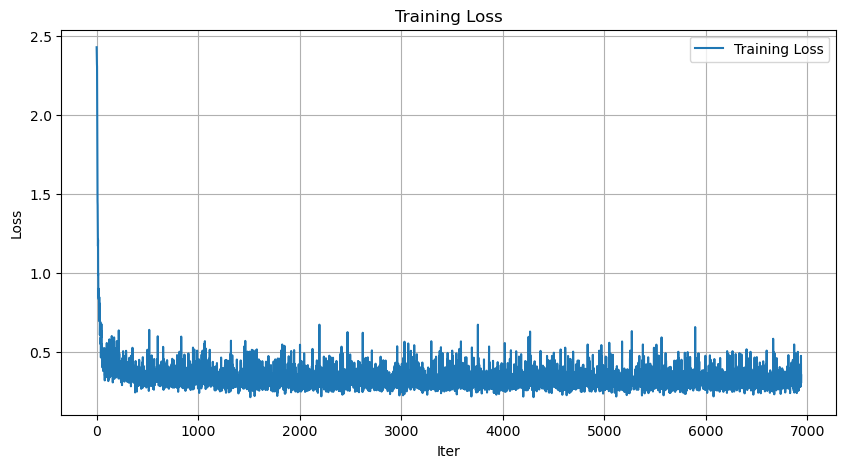

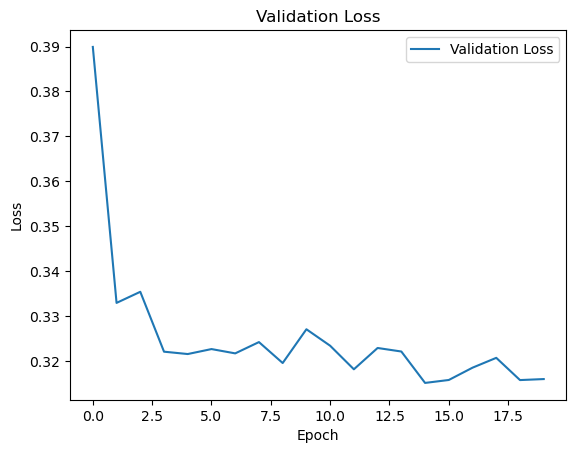

In [121]:
#plot loss
plot_loss(train_losses, val_losses)

In [122]:
#predict based on test data
model.eval()
test_data = test_data.to(device)
with torch.no_grad():
    predictions = model(test_data)
    
#inverse output of column 2-6 since these were scaled using log10 scale.
predictions[:, 1:] = 10 ** predictions[:, 1:]
print(f"prediction size: {predictions.shape}, \nprediction result : {predictions}")

#Move predictions tensor to CPU
predictions_np = predictions.cpu().numpy()

#generate df for predictions and load to .csv
predictions_df = pd.DataFrame({'id': test['id']})

for i, col_name in enumerate(config.CLASS_NAMES):
    predictions_df[col_name] = predictions_np[:, i]
    
print(f'predicton sample: {predictions_df.head(2)}')
predictions_df.to_csv('sample_prediction.csv', index=False)

prediction size: torch.Size([6545, 6]), 
prediction result : tensor([[5.6071e-01, 9.9383e+00, 5.9190e-01, 9.7814e-01, 1.5787e+00, 2.3615e+02],
        [4.5022e-01, 1.6863e+01, 4.3201e-01, 1.1215e+00, 1.3954e+00, 5.1712e+02],
        [4.4877e-01, 1.6727e+01, 4.2730e-01, 1.1037e+00, 1.4031e+00, 5.0170e+02],
        ...,
        [4.6968e-01, 1.6679e+01, 5.8151e-01, 1.6458e+00, 1.3782e+00, 6.3148e+02],
        [4.5859e-01, 1.6773e+01, 4.9629e-01, 1.3435e+00, 1.3868e+00, 5.6668e+02],
        [5.4369e-01, 1.4052e+01, 3.0994e+00, 9.8241e+00, 1.4592e+00, 2.0468e+03]],
       device='cuda:0')
predicton sample:           id   X4_mean   X11_mean  X18_mean  X26_mean  X50_mean  X3112_mean
0  201238668  0.560713   9.938299  0.591904  0.978141  1.578678  236.149506
1  202310319  0.450216  16.863012  0.432009  1.121512  1.395391  517.115479
